In [220]:
import math 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


In [221]:
# quadratic expression
def f(x):
    return 3*x**2 - 4*x + 5


In [222]:
f(-9)

284

In [223]:
xs= np.arange(-5,5,0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

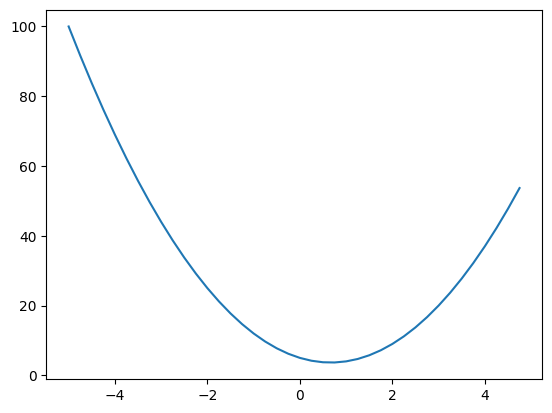

In [224]:
plt.plot(xs, ys)

In [225]:
h = 0.001
x = -3.0
#function
print(f(x))
# if we slightly nudge the x value
print(f(x+h))

#by how much has it(value of x) changed or how much the function responded in a positive direction.

print(f(x+h)- f(x))

#now we have to normalize by the run(h) to get the slope.
print((f(x+h)- f(x))/h)

44.0
43.978003
-0.021996999999998934
-21.996999999998934


In [226]:
#more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)




4.0


In [227]:
h = 0.0001

#inputs 
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c    

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)




d1 4.0
d2 3.999699999999999
slope -3.000000000010772


### to create the tanh function (below in the value class) that we will use further down  , we used this formula : 
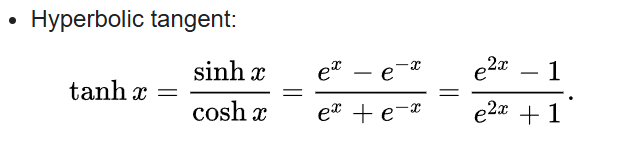

and the grad of tanh i,e d(tanhx)/dx  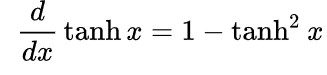

In [276]:
#building the value object.
#we know the childern of an ouptut and we know the operations which resulted the output(_children , _op)
class Value:
    def __init__(self, data, _children=(), _op='', label =''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        x = self.data
        # FIX: Correct the tanh formula with proper parentheses
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
             
    
# a = Value(2.0, label = 'a')
# b = Value(-3.0,  label = 'b')
# c = Value(10,  label = 'c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d*f; L.label = 'L'
# print(a)
# print(b)
# print(a+b)
# print(d)
# # print(a.__mul__(b).__add__(c))
# print(d._prev)
# print(d._op)
# print(L)

In [229]:
#to visualize the more complex expressions we use this function and graphiz
import graphviz
from graphviz import Digraph

In [230]:
def trace(root):
    #builds a set of all nodes and edge in a graph 
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes , edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        
        

    

In [231]:
draw_dot(L)
#this here is representing the forward pass of the mathematical experession.
# we now have to do backward pass(back-propagation to calculate the gradient along each intermediate values.)
#what we are really computing is for every single value here , we are trying to find the derivative of that node wrt to L.
#we are going to use the chain rule to do this. the chain rule is a fundamental rule
#in a neural network setting we'd be interested in finding the derivative of the loss function L wrt to weights of the neural network, in this case simple variables like a,b,c.
#these variables will eventually represent weights and biases of the NN.
#next we are going to create a variable 'grad' in the Value class, that maintains the derivative of L wrt to the specific value.
#self.grad = 0 , we intialize the grad to be 0 , because we assume at the start NN that every value does not impact the output.

NameError: name 'L' is not defined

# Manual calculations of Gradients.

lets calculate the grad for d and f 

1. for d it would be dL/dd
    formula :
    dL/dd = d(d*f)/dd = f 

2. for f it wold be dL/df
    formula :
    dL/df = d(d*f)/df = d

so grad for d = f(which is -2.0) and grad for f = d(which is 4.0)

we can cross check this within our lol function. change the variable by adding h to it and lets see what happens


now for the most important part of the gradient calculation , we need to understand dL/dc

for dL/dc we need to first understand dd/dc:
    as d = c+e
    dd/dc = d(c+e)/dc = (dc+de)/dc = dc/dc + de/dc , as we treat de as a constant becuase we are finding the partial differentiation i,e we are seeing what the changes are when we nudge the value of c i,e(c+h). so we treat every other variable as constant.
    so dd/dc = 1 + de/dc and de/dc = 0 as e is a constant.
    so dd/dc = 1

similarly dd/de = 1.

NOW, for the dL/dc we apply the chain rule from calculus.
i,e  If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y
i,e -> dz/dx = dz/dy * dy/dx

if we apply the chain rule here , 
for dL/dc = dL/dd * dd/dc = -2.0*1 = -2.0 = grad for c
for dL/de = dL/dd * dd/de = -2.0*1 = -2.0 = grad for e 

we can think in a network + symbol acts as a grad router , that means it just assigns the same grad to the next variables.

again we can cross check this in our lol function.

NOW we repeat the chain rule one last time for the last layer.
that is we need dL/db and dL/da
so for dL/db we need de/db first 
de/db = d(a*b)/db = a


and for dL/da we need de/da  
de/da = d(a*b)/da = b



now for dL/db = dL/de * de/db = -2.0 * 2.0
        dL/da = dL/de * de/da = -2.0 * -3.0

    so a.grad = -2.0 * -3.0
    b.grad = -2.0 * 2.0

again, lets confirm our calculations below using lol()

this is basically backpropagation, It is the recurvise application of the chain rule backwards through the computational graph.

In [232]:
#manual backprogation for the network.
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0 # -2 * -3
b.grad = -4.0 # -2 * 2


NameError: name 'L' is not defined

In [233]:
def lol():

    h = 0.001

    a = Value(2.0, label = 'a')
    b = Value(-3.0,  label = 'b')
    c = Value(10,  label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L' 
    L1 = L.data


    a = Value(2.0 ,label = 'a')
    b = Value(-3.0,  label = 'b')
    c = Value(10,  label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f') 
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

0.0


BackProp

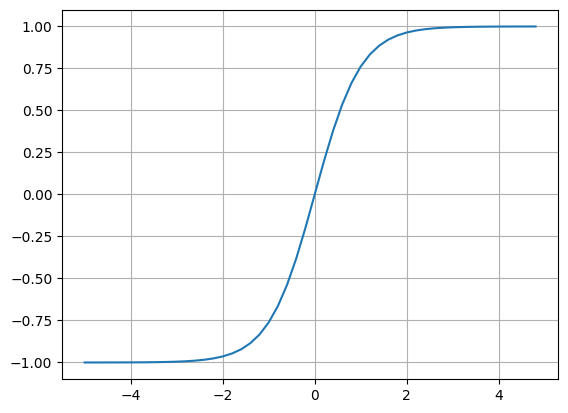

In [25]:
#Learning about activation functions (squashing functions)
#tanh
#before tanh
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2))); plt.grid();



Okay, so neuron is represented mathematically like this :


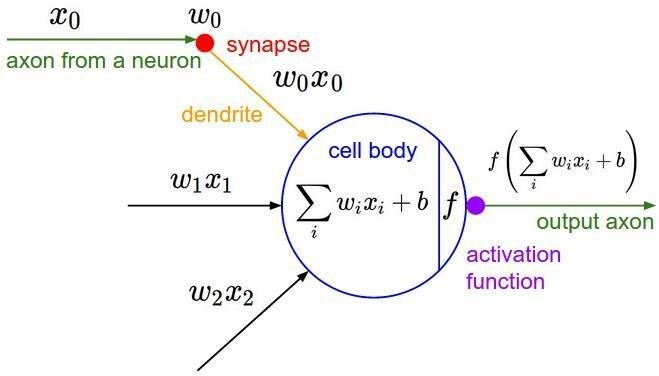

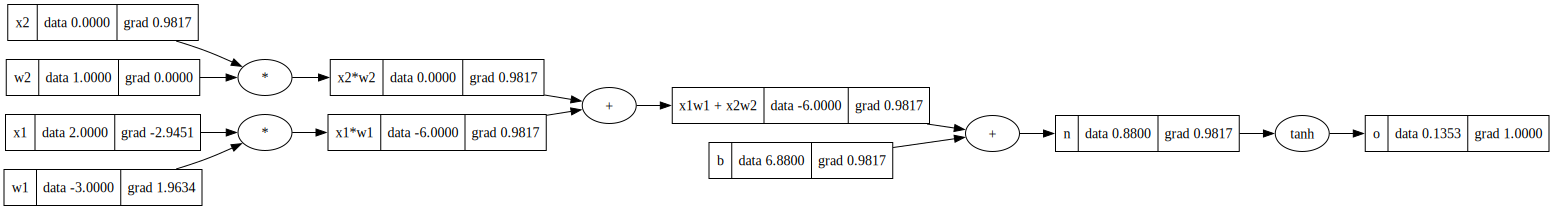

In [26]:
#lets build a 2D neuron 
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights 
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron 
b = Value(6.88, label = 'b')

#now according to the diagram 
#x1w1 + x2w2 +b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

#n now is the cell body without the activation function.
n = x1w1x2w2 + b ; n.label = 'n'

# we now to have take n thru an activation function in our case tanh 
o = n.tanh(); o.label = 'o' # we have not yet written tanh()
o.backward()
draw_dot(o)



In [28]:
#lets break up the tanh function from above using our new fucntions defined in the value class.
#lets build a 2D neuron 
#inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weights 
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of the neuron 
b = Value(6.88, label = 'b')

#now according to the diagram 
#x1w1 + x2w2 +b
x1w1 = x1 * w1 ; x1w1.label = 'x1*w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'

#n now is the cell body without the activation function.
n = x1w1x2w2 + b ; n.label = 'n'

# we will change how we define o


e = (2*n).exp() ; e.label = 'E'
o = (e+1)/(e-1) # as per the tanh formula



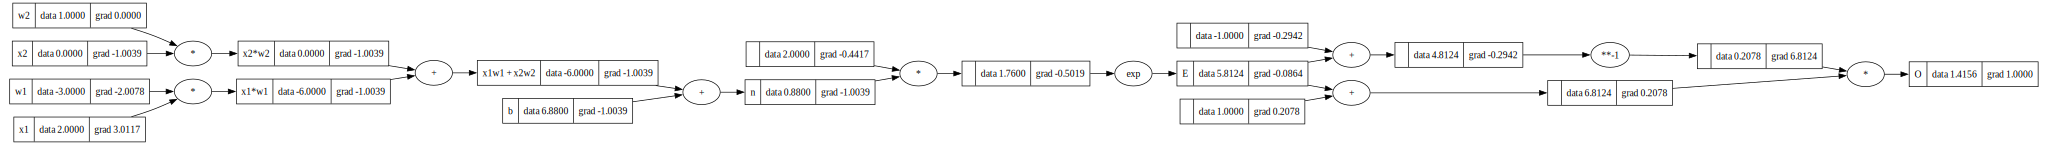

In [29]:

o.backward()

o.label = 'O'
draw_dot(o)

### Automatic backpropagation using _backward()

In [ ]:
o.grad = 1


In [44]:
o._backward()

In [46]:
n._backward()

In [ ]:
b._backward() # nothing would happen because b is a leaf node.


In [49]:
x1w1x2w2._backward()

In [53]:
x1w1._backward()

In [ ]:
x2w2._backward()


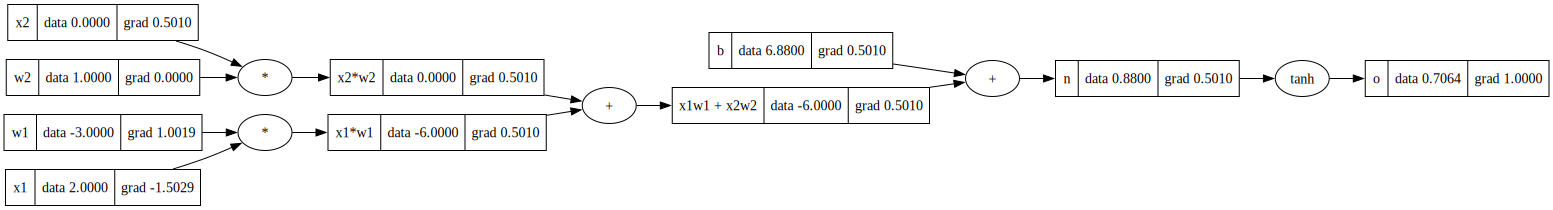

In [56]:
draw_dot(o)

### Automatic back prop

for auto back prop without having to call _backward() always, we need to implement topological graph(L to R DAG(directed acyclic graph)) .
what this tells us is basically the flow of the graph from left to right , all the variables data and the order to

now we have written the logic down , but to make it hidden we put this is in the value class by creating a backward function.

after creating the function in the value class , we can just call o.backward()

In [ ]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [67]:
o.backward()

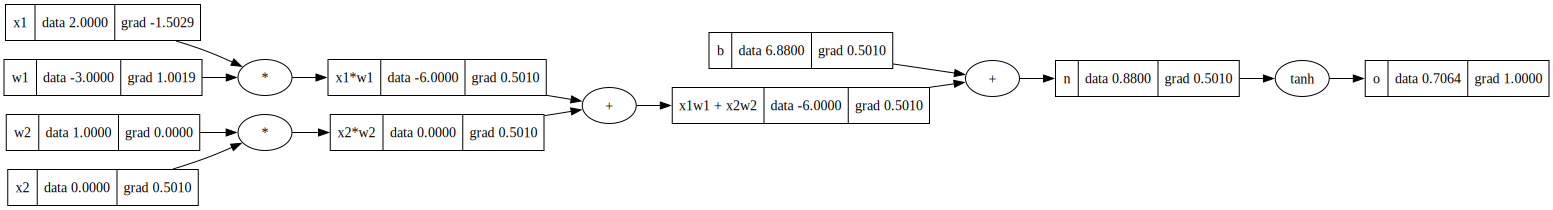

In [68]:
draw_dot(o)

### Manual backpropagation

in the setting of neural network what we really care about is the derivative of O wrt to the weights, as we will be changing the weights as means of optimization.
So lets calculate the grad of o first , as we know the base case, derivate of o wrt o is always 1

now we are going to back propagate through tanh , for that we need to know the local derivate of tanh.
we know that o = tanh(n) , so what we need is do/dn. 


we know that derivative of tanh is 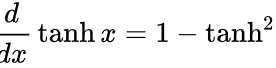  


that means , do/dn = 1-tanh(n)**2 , we know tanh(n) = o


so do/dn = 1-o**2


o = o.data == 0.70...


do/dn = 1-o.data**2


n.grad = 1-o.data**2

now for the next node , we know that + operator is a grad distributor


grad of  x1w1x2w2 and b will 0.5 respectively.

similarly grad of x1w1, x2w2 = 0.5(+ grad distributor)

for the next layer , local derivative rule for * is the par var * grad the previous node.

x1.grad = w2.data * x2w2.grad, same for the other terms.



In [34]:
o.grad = 1
n.grad = 0.5 #1-o.data**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad


x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

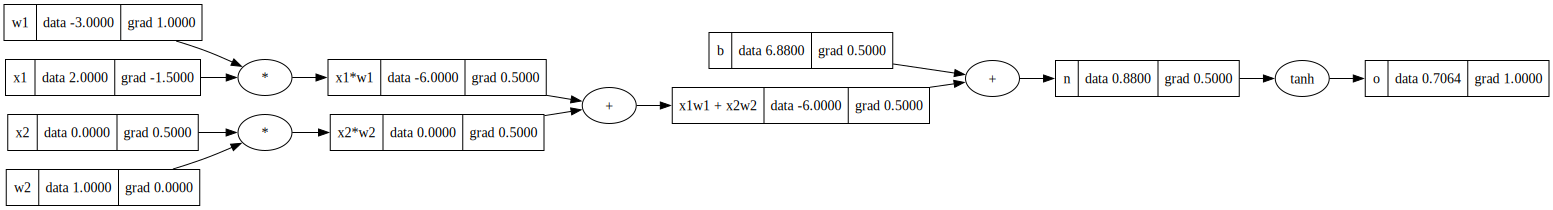

In [35]:
draw_dot(o)

we are now going to automate the manual back propagation process by creating a _backward() function in the value class.

### Fixing a bug

We have a bug ,lets look at it 
in the simple function below , when we define b as a + a , the gradient of a should be 2 db/da , b = a+a , d(a+a)/db = 2.
but here we are getting the grad of a as 1, which is wrong.

what is happening is, in this function : 
def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

when we add a+a , self.grad will be 1, and then other.grad will also be 1 , as self and other are the same in this case, but this is not right.
when we take a look at multivariable case of the chainrule  , it tells us to accumilate the gradients of each , that means adding them up. We will see this bug whenver we use the same variable more than once.

so to change that , we have to use += instead of = . this should be okay because we are intializing them at 0 (i,e self.grad =0.0)


we can get a better look at the problem if we use a more complex example.

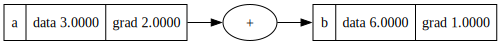

In [ ]:
a = Value(3.0 , label= 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

#its now working


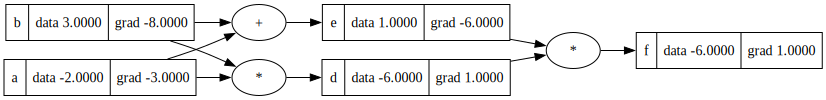

In [ ]:
a = Value(-2.0, label='a')
b= Value(3.0, label= 'b')

d = a*b ; d.label = 'd'
e = a+b ; e.label ='e'
f = d*e; f.label = 'f'

f.backward()
draw_dot(f)

# this also works


### we now change the tanh function in the value class, essentially breaking it up and using more operations to define it.
### we defined it before as this : 
 
 
        def tanh(self):
                x = self.data 
                t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
                out = Value(t, (self, ), 'tanh')

                def _backward():
                    self.grad += (1- t ** 2) * out.grad

                out._backward = _backward
                return out 
    


## Same thing but in pytorch 

In [234]:
import torch 
# for us to make the values like we need while building a neuron 
# a tensor is the primary data structure in pytorch similar to a numpy array.
# .double is to convert 32 bit float to convert to a 64 bit float.
# and also because they are leaf nodes , pytorch assumes that they do not require gradients , that is why we mention requires_grad = True.


#inputs 
X1 = torch.Tensor([2.0]).double()      ; X1.requires_grad = True 
X2 = torch.Tensor([0.0]).double()      ; X2.requires_grad = True 

#weights 
W1 = torch.Tensor([-3.0]).double()     ; W1.requires_grad = True
W2 = torch.Tensor([1.0]).double()      ; W2.requires_grad = True

#bias
B = torch.Tensor([6.88137]).double()   ; B.requires_grad = True

N = X1*W1 + X2*W2 + B 

O = torch.tanh(N)

print(O.data.item())
O.backward()

print('-----------')
print('X1 grad:', X1.grad.item())
print('X2 grad:', X2.grad.item())
print('W1 grad:', W1.grad.item())
print('W2 grad:', W2.grad.item())
                            
# so as we can see , pytorch can do exactly what we did in micrograd if its a single node but more efficiently because of the tensors

0.7071050214706146
-----------
X1 grad: -1.500007465833125
X2 grad: 0.5000024886110417
W1 grad: 1.0000049772220834
W2 grad: 0.0


### now lets build some neural nets using micrograd 
we will first start by building a neural net piece by piece and then move to a MLP(multilayer perceptron)



MLP - 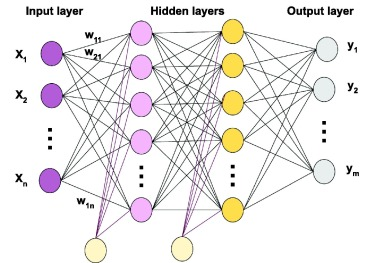

In [277]:
#implementing a single neuron 
import random
class Neuron :

    def __init__(self , nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights 
        self.b = Value(random.uniform(-1,1))# bias of the neuron that controls the overall trigger happiness of this neuron 

    def __call__(self,x):
        #we have to do w*x + b  (dot product) --cell body calculation in the neuron (refer diagram)
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # pairs w with x
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer :
    def __init__(self, nin , nout):
        # A layer is just a list of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self , x):
        outs = [n(x) for n in self.neurons]
        # FIX: Return the single value if there's only one, otherwise return the list.
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params

class MLP:
    #Multilayer perceptron 
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
    



In [278]:
x = [2.0, 3.0, -1.0 ]
n = MLP(3, [4, 4, 1])
n(x) # when you use n(x)python will use __cal__  method

Value(data=0.7195070815870853, grad=0)

In [279]:
len(n.parameters())

41

In [147]:
# draw_dot(n(x))

In [280]:
#sample data set to test 
#simple binary classifier neural net 

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0 , -1.0],
]

#desired target 
ys = [1.0, -1.0, -1.0 , 1.0]


#preds should be ys , so how do we tune the weights to better predict the desired outputs
# we have to calculate the loss 



In [ ]:
# --- THE TRAINING LOOP ---
# Run the training for, say, 20 epochs (iterations)
for epoch in range(20):
    
    # 1. Forward pass: get predictions
    ypreds = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypreds)])
    
    # 2. Zero the gradients before the backward pass
    for p in n.parameters():
        p.grad = 0.0
    
    # 3. Backward pass: compute gradients
    loss.backward()
    
    # 4. Update weights (gradient descent)
    # Using a slightly smaller learning rate (e.g., 0.05) is often more stable
    for p in n.parameters():
        p.data += -0.1 * p.grad
        
    print(f"Epoch {epoch+1}, Loss: {loss.data}")

Epoch 1, Loss: 0.00018193603243809992
Epoch 2, Loss: 0.0001818405948086555
Epoch 3, Loss: 0.00018174525400394524
Epoch 4, Loss: 0.00018165000987876875
Epoch 5, Loss: 0.00018155486228820073
Epoch 6, Loss: 0.0001814598110876139
Epoch 7, Loss: 0.00018136485613266538
Epoch 8, Loss: 0.00018126999727929378
Epoch 9, Loss: 0.00018117523438372228
Epoch 10, Loss: 0.00018108056730246363
Epoch 11, Loss: 0.000180985995892312
Epoch 12, Loss: 0.00018089152001034216
Epoch 13, Loss: 0.00018079713951391958
Epoch 14, Loss: 0.00018070285426067704
Epoch 15, Loss: 0.00018060866410853546
Epoch 16, Loss: 0.00018051456891570174
Epoch 17, Loss: 0.00018042056854065527
Epoch 18, Loss: 0.00018032666284215374
Epoch 19, Loss: 0.0001802328516792348
Epoch 20, Loss: 0.00018013913491121957


In [ ]:
ypreds 
# as you can see the preds are very close to the actual target variables.

[Value(data=0.9938439003658548, grad=-0.012312199268290414),
 Value(data=-0.9918608187749989, grad=0.01627836245000225),
 Value(data=-0.9953608437948209, grad=0.009278312410358147),
 Value(data=0.9926193814015196, grad=-0.014761237196960764)]

In [394]:
#these are setting of the weights and parameteres that makes our network predict accurate targets
n.parameters()

[Value(data=0.6121736605141631, grad=4.013773755471768e-05),
 Value(data=-1.1357894847502001, grad=3.708795449834162e-05),
 Value(data=1.1854104552844662, grad=-5.115307143856466e-05),
 Value(data=0.684215815466342, grad=3.534192132683962e-05),
 Value(data=-1.1345450938890975, grad=-2.1465439660563854e-05),
 Value(data=0.2647590068336543, grad=-2.63658169999696e-05),
 Value(data=-0.18763947630974032, grad=2.060512672566647e-05),
 Value(data=-0.34681598596601054, grad=-1.4555148056844004e-05),
 Value(data=-0.5015429684225545, grad=-5.0132151384329396e-05),
 Value(data=0.1582817071124316, grad=5.563336220434072e-05),
 Value(data=0.35433447329581264, grad=-5.5597630739721896e-05),
 Value(data=0.025908390922793866, grad=-1.8365695445952004e-05),
 Value(data=0.08421548592590138, grad=-0.00013287017919056462),
 Value(data=-0.2890913941572942, grad=6.633401925280132e-05),
 Value(data=1.256291889324554, grad=-6.960406494929409e-05),
 Value(data=0.006866863069469216, grad=-4.335029843066819e-05